In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split as tts

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Opening the dataset as pandaas dataframe

In [2]:
jobPost = pd.read_csv('fake_job_postings.csv')
jobPost.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Resampling the dataset

In [3]:
# Making balanced data sets

fake_df = jobPost[jobPost['fraudulent']==1]
real_df =jobPost[jobPost['fraudulent']==0]

# re-sampling the data
fake_df=fake_df.sample(17014,replace=True)
jobPost = pd.concat([fake_df, real_df], ignore_index=True)
jobPost.reset_index()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,6808,Integrity Management Engineering Specialist,"US, TX, Houston",Engineering,NaN,NaN,Position Summary: Provide integrity engineeri...,Job RequirementsTechnical Requirements:Experie...,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
1,1,4358,Subsea Process Plant Layout Designer,"US, TX, Houston",NaN,NaN,NaN,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributesQualif...,We offer• Friendly colleagues in an industry w...,0,0,0,NaN,NaN,NaN,Oil & Energy,Engineering,1
2,2,17694,Appointment setter,"US, IL, Chicago",NaN,NaN,Looking for adventurous people to join a thriv...,The desired candidate will work in a fast pace...,Must have computer abilitymust have a great at...,profit sharingbonus,0,0,0,Contract,Entry level,Unspecified,Automotive,Customer Service,1
3,3,8433,Operator Mechanic 1,"US, CA, City of Industry",Oil & Energy,NaN,...,"Job Responsibilities:* Start-up, operate and s...",Qualifications:Thorough knowledge of electrica...,NaN,0,1,1,Full-time,Mid-Senior level,Certification,Oil & Energy,Management,1
4,4,5601,Office Assistant,"US, CA, SAN DIEGO",NaN,NaN,NaN,"General PurposeProvides administrative, secret...",Education and ExperienceHigh School Diploma or...,NaN,0,0,0,Full-time,NaN,Unspecified,NaN,Administrative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34023,34023,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
34024,34024,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
34025,34025,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
34026,34026,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


### Removing columns that have no correlation with the posting being fraudulent

In [4]:
jobPost.drop(['salary_range','company_profile','description','requirements','benefits'], axis = 1, inplace=True)
jobPost.fillna('0', inplace=True)

## Tokenization and vectorization

In [5]:
def make2list(series):
    for i in range(len(jobPost.index)):
        holder = jobPost['location'].iloc[i]
        if(isinstance(holder, str) == False):
            holder = str(holder)
        holder = holder.split(', ')
        jobPost['location'].at[i] = holder
    return series    

In [6]:
jobPost['location'] = make2list(jobPost['location'])

In [7]:
def listToString(s):
 
    # initialize an empty string
    str1 = ""
    # traverse in the string
    for ele in s:
        str1 += ele
    # return string
    return str1

In [8]:
def takeN(series, n):
    isList = isinstance(series.iloc[0],list)
    for i in range(len(series.index)):
        if(isList):
            values = series.iloc[i]
            values = values[:n]
            if(n == 1):
                values = listToString(values)
            series.at[i] = values
    
    return series

In [9]:
jobPost['location'] = takeN(jobPost['location'], 1)

In [10]:
def lst(series):
    lst = ''
    lst = list(lst)
    for i in range(len(series.index)):
        if (isinstance(series.iloc[i],list)):
            values = series.iloc[i]
            for value in values:
                if value not in lst:
                    lst.append(value)
        else: 
            value = series.iloc[i]
            if value not in lst:
                lst.append(value)  
    return lst

In [11]:
EMP_type_lst = lst(jobPost['employment_type'])
print(EMP_type_lst)
print(len(EMP_type_lst))

['0', 'Contract', 'Full-time', 'Part-time', 'Temporary', 'Other']
6


In [12]:
Edu_req_lst = lst(jobPost['required_education'])
print(Edu_req_lst)
print(len(Edu_req_lst))

['0', 'Unspecified', 'Certification', 'High School or equivalent', "Master's Degree", 'Some High School Coursework', "Bachelor's Degree", 'Associate Degree', 'Some College Coursework Completed', 'Professional', 'Doctorate', 'Vocational', 'Vocational - Degree', 'Vocational - HS Diploma']
14


In [13]:
Exp_req_lst = lst(jobPost['required_experience'])
print(Exp_req_lst)
print(len(Exp_req_lst))

['0', 'Entry level', 'Mid-Senior level', 'Director', 'Associate', 'Not Applicable', 'Executive', 'Internship']
8


In [14]:
#we now have idea on the amount of unique entries
#so now we can choose if a column should be rescaled into ranks or one-hot-vectored

Emp_dict = {'0'         : 0,
            'Other'     : 1,
            'Temporary' : 2,
            'Part-time' : 3,
            'Contract'  : 4,
            'Full-time' : 5
           }

Edu_dict = {'0'                                  : 0,
            'Unspecified'                        : 1,
            'Some High School Coursework'        : 2,
            'High School or equivalent'          : 3,
            'Vocational'                         : 4,
            'Vocational - HS Diploma'            : 5,
            'Certification'                      : 6,
            'Some College Coursework Completed'  : 7,
            'Associate Degree'                   : 8,
            'Vocational - Degree'                : 9,
            "Bachelor's Degree"                  :10,
            "Master's Degree"                    :11,
            'Professional'                       :12,
            'Doctorate'                          :13
            }

Exp_dict = {'0'                :0,
            'Not Applicable'   :1,
            'Internship'       :2,
            'Entry level'      :3,
            'Associate'        :4,
            'Mid-Senior level' :5,
            'Executive'        :6,
            'Director'         :7
           }

In [15]:
def rank(series,dictname):
    for i in range(len(series.index)):
        key = series.iloc[i]
        series.at[i] = dictname[key]
    return series

In [16]:
jobPost['employment_type'] = rank(jobPost['employment_type'], Emp_dict)
jobPost['required_education'] = rank(jobPost['required_education'], Edu_dict)
jobPost['required_experience'] = rank(jobPost['required_experience'], Exp_dict)

jobPost.head()

,job_id,title,location,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,6808,Integrity Management Engineering Specialist,US,Engineering,0,0,0,0,0,0,0,0,1
1,4358,Subsea Process Plant Layout Designer,US,0,0,0,0,0,0,0,Oil & Energy,Engineering,1
2,17694,Appointment setter,US,0,0,0,0,4,3,1,Automotive,Customer Service,1
3,8433,Operator Mechanic 1,US,Oil & Energy,0,1,1,5,5,6,Oil & Energy,Management,1
4,5601,Office Assistant,US,0,0,0,0,5,0,1,0,Administrative,1


In [17]:
jobPost['employment_type'] = jobPost['employment_type'].astype(int)
jobPost['required_education'] = jobPost['required_education'].astype(int)
jobPost['required_experience'] = jobPost['required_experience'].astype(int)

In [18]:
jobPost = pd.get_dummies(jobPost, columns=['location'], dtype = int)
jobPost = pd.get_dummies(jobPost, columns=['department'], dtype = int)
jobPost = pd.get_dummies(jobPost, columns=['industry'], dtype = int)
jobPost = pd.get_dummies(jobPost, columns=['function'], dtype = int)

In [19]:
jobPost = jobPost.replace('0', 0)

# Simple Neural Network Model

### Splitting the data into train and test

In [20]:
train_set, test_set = tts(jobPost, test_size = 0.2)


X_train = train_set.drop(['job_id','title','fraudulent'], axis = 1)
Y_train = train_set['fraudulent']

X_test = test_set.drop(['job_id','title','fraudulent'], axis = 1)
Y_test = test_set['fraudulent']

X_NN = X_train.values
Y_NN = Y_train.values

X_NN = torch.FloatTensor(X_NN)
Y_NN = torch.LongTensor(Y_NN)

### Creating the model

In [21]:
#create a neural network from the pytorch module, 1 input layer, 6 hidden layer, 1 output
class Predict(nn.Module):
    def __init__(self, predictor = 1604,
                 h1 = 30, h2 = 20, h3 = 15, h4 = 13, h5 = 10,
                 h6 = 9, predict = 2):
        super().__init__()
        self.fc1 = nn.Linear(predictor , h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.fc6 = nn.Linear(h5, h6)
        self.out = nn.Linear(h6, predict)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.out(x)
        
        return x
    
predict = Predict()
print(predict)

Predict(
  (fc1): Linear(in_features=1604, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=15, bias=True)
  (fc4): Linear(in_features=15, out_features=13, bias=True)
  (fc5): Linear(in_features=13, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=2, bias=True)
)


In [22]:
# Set criterion
criterion = nn.CrossEntropyLoss()

# Choose Optimizer
optimizer = torch.optim.Adam(predict.parameters(), lr=0.025)

### Training the model

In [23]:
epoch = 700
losses = list()

for i in range(epoch):
    # passing inputs through the network
    y_pred = predict.forward(X_NN)
    
    # measure the loss at each iteration
    loss = criterion(y_pred,Y_NN)
   
    # keep track of progress
    losses.append(loss.detach().numpy())
    
    print(f'epoch: {i} | loss {loss}')
    
    # optimizing the model/feedback
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 0 | loss 0.6942626237869263
epoch: 1 | loss 0.6931670308113098
epoch: 2 | loss 0.6925265789031982
epoch: 3 | loss 0.687920868396759
epoch: 4 | loss 0.6782912611961365
epoch: 5 | loss 0.657691478729248
epoch: 6 | loss 0.6248565912246704
epoch: 7 | loss 0.5758444666862488
epoch: 8 | loss 0.5100228190422058
epoch: 9 | loss 0.4735533595085144
epoch: 10 | loss 0.44940632581710815
epoch: 11 | loss 0.41931286454200745
epoch: 12 | loss 0.3959256112575531
epoch: 13 | loss 0.38409990072250366
epoch: 14 | loss 0.3338979482650757
epoch: 15 | loss 0.35498061776161194
epoch: 16 | loss 0.32032784819602966
epoch: 17 | loss 0.315656840801239
epoch: 18 | loss 0.2599285840988159
epoch: 19 | loss 0.30381375551223755
epoch: 20 | loss 0.2614809274673462
epoch: 21 | loss 0.28690633177757263
epoch: 22 | loss 0.2349950224161148
epoch: 23 | loss 0.264186829328537
epoch: 24 | loss 0.22664788365364075
epoch: 25 | loss 0.24105387926101685
epoch: 26 | loss 0.23168306052684784
epoch: 27 | loss 0.2150717228651

Text(0.5, 0, 'Epoch')

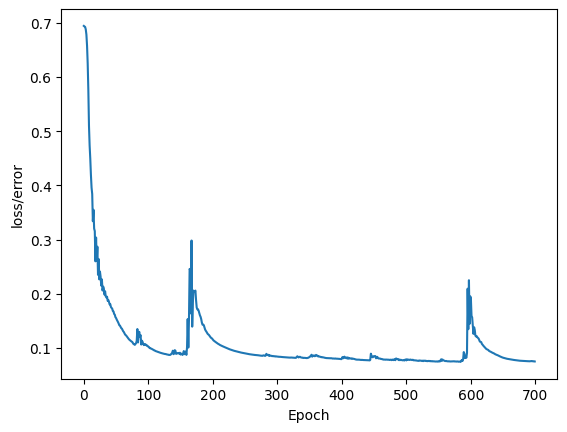

In [24]:
#Graphing the loss over iterations
plt.plot(range(epoch),losses)
plt.ylabel('loss/error')
plt.xlabel('Epoch')

### Testing the model

In [25]:
X_testNN = X_test.values
Y_testNN = Y_test.values

X_testNN = torch.FloatTensor(X_testNN)
Y_testNN = torch.LongTensor(Y_testNN)

In [26]:
with torch.no_grad():
    y_eval = predict.forward(X_testNN)
    loss = criterion(y_eval, Y_testNN)

In [27]:
correct = 0

y_pred = []

with torch.no_grad():
    for i, data in enumerate(X_testNN):
        y_val = predict.forward(data)
        y_pred.append(y_val.argmax().item())
    
        if y_val.argmax().item() == Y_testNN[i]: 
            correct += 1

accuracy = correct/len(y_pred)            
print(f'Test accuracy = {accuracy}')
    
Y_pred = pd.DataFrame(y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, Y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse}")

Test accuracy = 0.9628269174258007
Mean Absolute Error: 0.03717308257419923
Mean Squared Error: 0.03717308257419923
